# **Basic Wan2.1 VACE Workflow with CausVid LoRA for Image to Video**
- You can use the T4 GPU to generate a 4 second video with the default settings (width=432, height=768, causvid_lora_strength=0.8, steps=4, frames=65) without crashing your session. The first video(15fps) takes about 10 minutes, while the second video(30fps) is generated a few seconds later. You can increase the steps for better video quality at the cost of increased generation time.
- The default settings may crash the L4 GPU, even though it has more resources than the T4. This is likely due to memory fragmentation caused by the low image resolution. To avoid this, increase the resolution to at least 480×832. With this resolution, the L4 GPU successfully generates a 5-second  video(frames=81) in about 5 minutes. You may also need to switch the sampler from uni_pc to euler_ancestral to avoid the CUSOLVER_STATUS_INTERNAL_ERROR which can occasionally occur.
- If you want to increase the number of frames without crashing the T4, then reduce the width and height of the video, and they should be divisible by 16.
- If you want to generate a video with the CausVid lora disabled, then set steps to 20 and cfg_scale to 4.

In [ ]:
# @title Prepare Environment
!pip install torch==2.6.0 torchvision==0.21.0
%cd /content

from IPython.display import clear_output

!git clone --branch ComfyUI_v0.3.36 https://github.com/Isi-dev/ComfyUI
%cd /content/ComfyUI/custom_nodes
!git clone https://github.com/Isi-dev/ComfyUI_GGUF.git
%cd /content/ComfyUI/custom_nodes/ComfyUI_GGUF
!pip install -r requirements.txt
clear_output()

%cd /content
!git clone https://github.com/Isi-dev/Practical-RIFE
%cd /content/Practical-RIFE
!pip install git+https://github.com/rk-exxec/scikit-video.git@numpy_deprecation
!mkdir -p /content/Practical-RIFE/train_log
!wget -q https://huggingface.co/Isi99999/Frame_Interpolation_Models/resolve/main/4.25/train_log/IFNet_HDv3.py -O /content/Practical-RIFE/train_log/IFNet_HDv3.py
!wget -q https://huggingface.co/Isi99999/Frame_Interpolation_Models/resolve/main/4.25/train_log/RIFE_HDv3.py -O /content/Practical-RIFE/train_log/RIFE_HDv3.py
!wget -q https://huggingface.co/Isi99999/Frame_Interpolation_Models/resolve/main/4.25/train_log/refine.py -O /content/Practical-RIFE/train_log/refine.py
!wget -q https://huggingface.co/Isi99999/Frame_Interpolation_Models/resolve/main/4.25/train_log/flownet.pkl -O /content/Practical-RIFE/train_log/flownet.pkl
clear_output()

%cd /content/ComfyUI

import subprocess
import sys


def install_pip_packages():
    packages = [
        'torchsde',
        'av',
        'diffusers',
        'transformers',
        'xformers==0.0.29.post2',
        'accelerate',
        # 'omegaconf',
        'tqdm',
        # 'librosa',
        # 'triton',
        # 'sageattention',
        'color-matcher',
        'einops'
    ]

    for package in packages:
        try:
            # Run pip install silently (using -q)
            subprocess.run(
                [sys.executable, '-m', 'pip', 'install', '-q', package],
                check=True,
                capture_output=True
            )
            print(f"✓ {package} installed")
        except subprocess.CalledProcessError as e:
            print(f"✗ Error installing {package}: {e.stderr.decode().strip() or 'Unknown error'}")

def install_apt_packages():
    packages = ['aria2']

    try:
        # Run apt install silently (using -qq)
        subprocess.run(
            ['apt-get', '-y', 'install', '-qq'] + packages,
            check=True,
            capture_output=True
        )
        print("✓ apt packages installed")
    except subprocess.CalledProcessError as e:
        print(f"✗ Error installing apt packages: {e.stderr.decode().strip() or 'Unknown error'}")

# Run installations
print("Installing pip packages...")
install_pip_packages()
clear_output()  # Clear the pip installation output

print("Installing apt packages...")
install_apt_packages()
clear_output()  # Clear the apt installation output

print("Installation completed with status:")
print("- All pip packages installed successfully" if '✗' not in install_pip_packages.__code__.co_consts else "- Some pip packages had issues")
print("- apt packages installed successfully" if '✗' not in install_apt_packages.__code__.co_consts else "- apt packages had issues")


import torch
import numpy as np
from PIL import Image
import gc
import sys
import random
import os
import imageio
import subprocess
from google.colab import files
from IPython.display import display, HTML, Image as IPImage
import glob
from IPython.display import Video as outVid
import datetime
sys.path.insert(0, '/content/ComfyUI')

from comfy import model_management

from nodes import (
    CheckpointLoaderSimple,
    CLIPLoader,
    CLIPTextEncode,
    VAEDecode,
    VAELoader,
    KSampler,
    UNETLoader,
    LoraLoaderModelOnly,
    ImageScale,
    LoadImage
    # CLIPVisionLoader,
    # CLIPVisionEncode
)

from custom_nodes.ComfyUI_GGUF.nodes import UnetLoaderGGUF
from comfy_extras.nodes_model_advanced import ModelSamplingSD3
from comfy_extras.nodes_images import SaveAnimatedWEBP
from comfy_extras.nodes_video import SaveWEBM
from comfy_extras.nodes_wan import WanVaceToVideo
from comfy_extras.nodes_wan import TrimVideoLatent

from pathlib import Path

def download_with_aria2c(link, folder="/content/ComfyUI/models/loras"):
    import os

    filename = link.split("/")[-1]
    command = f"aria2c --console-log-level=error -c -x 16 -s 16 -k 1M {link} -d {folder} -o {filename}"

    print("Executing download command:")
    print(command)

    os.makedirs(folder, exist_ok=True)
    get_ipython().system(command)

    return filename

def download_civitai_model(civitai_link, civitai_token, folder="/content/ComfyUI/models/loras"):
    import os
    import time

    os.makedirs(folder, exist_ok=True)

    try:
        model_id = civitai_link.split("/models/")[1].split("?")[0]
    except IndexError:
        raise ValueError("Invalid Civitai URL format. Please use a link like: https://civitai.com/api/download/models/1523247?...")

    civitai_url = f"https://civitai.com/api/download/models/{model_id}?type=Model&format=SafeTensor"
    if civitai_token:
        civitai_url += f"&token={civitai_token}"

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    filename = f"model_{timestamp}.safetensors"

    full_path = os.path.join(folder, filename)

    download_command = f"wget --max-redirect=10 --show-progress \"{civitai_url}\" -O \"{full_path}\""
    print("Downloading from Civitai...")

    os.system(download_command)

    local_path = os.path.join(folder, filename)
    if os.path.exists(local_path) and os.path.getsize(local_path) > 0:
        print(f"LoRA downloaded successfully: {local_path}")
    else:
        print(f"❌ LoRA download failed or file is empty: {local_path}")

    return filename


def download_lora(link, folder="/content/ComfyUI/models/loras", civitai_token=None):
    """
    Download a model file, automatically detecting if it's a Civitai link or huggingface download.

    Args:
        link: The download URL (either huggingface or Civitai)
        folder: Destination folder for the download
        civitai_token: Optional token for Civitai downloads (required if link is from Civitai)

    Returns:
        The filename of the downloaded model
    """
    if "civitai.com" in link.lower():
        if not civitai_token:
            raise ValueError("Civitai token is required for Civitai downloads")
        return download_civitai_model(link, civitai_token, folder)
    else:
        return download_with_aria2c(link, folder)



def model_download(url: str, dest_dir: str, filename: str = None, silent: bool = True) -> bool:
    """
    Colab-optimized download with aria2c

    Args:
        url: Download URL
        dest_dir: Target directory (will be created if needed)
        filename: Optional output filename (defaults to URL filename)
        silent: If True, suppresses all output (except errors)

    Returns:
        bool: True if successful, False if failed
    """
    try:
        # Create destination directory
        Path(dest_dir).mkdir(parents=True, exist_ok=True)

        # Set filename if not specified
        if filename is None:
            filename = url.split('/')[-1].split('?')[0]  # Remove URL parameters

        # Build command
        cmd = [
            'aria2c',
            '--console-log-level=error',
            '-c', '-x', '16', '-s', '16', '-k', '1M',
            '-d', dest_dir,
            '-o', filename,
            url
        ]

        # Add silent flags if requested
        if silent:
            cmd.extend(['--summary-interval=0', '--quiet'])
            print(f"Downloading {filename}...", end=' ', flush=True)

        # Run download
        result = subprocess.run(cmd, check=True, capture_output=True, text=True)

        if silent:
            print("Done!")
        else:
            print(f"Downloaded {filename} to {dest_dir}")
        return filename

    except subprocess.CalledProcessError as e:
        error = e.stderr.strip() or "Unknown error"
        print(f"\nError downloading {filename}: {error}")
        return False
    except Exception as e:
        print(f"\nError: {str(e)}")
        return False


model_quant = "Q5_K_M" # @param ["Q4_K_M", "Q5_0", "Q5_K_M", "Q6_K", "Q8_0"]

download_loRA_1 = False # @param {type:"boolean"}
lora_1_download_url = "Put your loRA here"# @param {"type":"string"}

download_loRA_2 = False # @param {type:"boolean"}
lora_2_download_url = "https://civitai.com/api/download/models/1547106?type=Model&format=SafeTensor"# @param {"type":"string"}

token_if_civitai_url = "fd4ab8e56aa05da389f4f5548d73f4b4"# @param {"type":"string"}

lora_1 = None
if download_loRA_1:
    lora_1 = download_lora(lora_1_download_url, civitai_token=token_if_civitai_url)
# Validate loRA file extension
valid_extensions = {'.safetensors', '.ckpt', '.pt', '.pth', '.sft'}
if lora_1:
    if not any(lora_1.lower().endswith(ext) for ext in valid_extensions):
        print(f"❌ Invalid LoRA format: {lora_1}")
        lora_1 = None
    else:
        clear_output()
        print("loRA 1 downloaded succesfully!")

lora_2 = None
if download_loRA_2:
    lora_2 = download_lora(lora_2_download_url, civitai_token=token_if_civitai_url)
if lora_2:
    if not any(lora_2.lower().endswith(ext) for ext in valid_extensions):
        print(f"❌ Invalid LoRA format: {lora_2}")
        lora_2 = None
    else:
        clear_output()
        print("loRA 2 downloaded succesfully!")


# !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Comfy-Org/Wan_2.1_ComfyUI_repackaged/resolve/main/split_files/clip_vision/clip_vision_h.safetensors -d /content/ComfyUI/models/clip_vision -o clip_vision_h.safetensors

# model_quant = "Q8_0"

if model_quant == "Q4_K_M":
    dit_model = model_download("https://huggingface.co/QuantStack/Wan2.1-VACE-14B-GGUF/resolve/main/Wan2.1-VACE-14B-Q4_K_M.gguf", "/content/ComfyUI/models/diffusion_models")
elif model_quant == "Q5_0":
    dit_model = model_download("https://huggingface.co/QuantStack/Wan2.1-VACE-14B-GGUF/resolve/main/Wan2.1-VACE-14B-Q5_0.gguf", "/content/ComfyUI/models/diffusion_models")
elif model_quant == "Q5_K_M":
    dit_model = model_download("https://huggingface.co/Isi99999/Wan2.1BasedModels/resolve/main/Wan2.1-VACE-14B-Q5_K_M.gguf", "/content/ComfyUI/models/diffusion_models")
elif model_quant == "Q6_K":
    dit_model = model_download("https://huggingface.co/Isi99999/Wan2.1BasedModels/resolve/main/Wan2.1-VACE-14B-Q6_K.gguf", "/content/ComfyUI/models/diffusion_models")
else:
    dit_model = model_download("https://huggingface.co/Isi99999/Wan2.1BasedModels/resolve/main/Wan2.1-VACE-14B-Q8_0.gguf", "/content/ComfyUI/models/diffusion_models")
causvid_lora = model_download("https://huggingface.co/Isi99999/Wan2.1BasedModels/resolve/main/Wan21_CausVid_14B_T2V_lora_rank32.safetensors", "/content/ComfyUI/models/loras")
# causvid_lora = model_download("https://huggingface.co/Kijai/WanVideo_comfy/resolve/main/Wan21_CausVid_14B_T2V_lora_rank32_v2.safetensors", "/content/ComfyUI/models/loras")
text_encoder = model_download("https://huggingface.co/Comfy-Org/Wan_2.1_ComfyUI_repackaged/resolve/main/split_files/text_encoders/umt5_xxl_fp8_e4m3fn_scaled.safetensors", "/content/ComfyUI/models/text_encoders")
vae_model = model_download("https://huggingface.co/Comfy-Org/Wan_2.1_ComfyUI_repackaged/resolve/main/split_files/vae/wan_2.1_vae.safetensors", "/content/ComfyUI/models/vae")


def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    for obj in list(globals().values()):
        if torch.is_tensor(obj) or (hasattr(obj, "data") and torch.is_tensor(obj.data)):
            del obj
    gc.collect()

def save_as_mp4(images, filename_prefix, fps, output_dir="/content/ComfyUI/output"):
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.mp4"

    frames = [(img.cpu().numpy() * 255).astype(np.uint8) for img in images]

    with imageio.get_writer(output_path, fps=fps) as writer:
        for frame in frames:
            writer.append_data(frame)

    return output_path

def save_as_webp(images, filename_prefix, fps, quality=90, lossless=False, method=4, output_dir="/content/ComfyUI/output"):
    """Save images as animated WEBP using imageio."""
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.webp"


    frames = [(img.cpu().numpy() * 255).astype(np.uint8) for img in images]


    kwargs = {
        'fps': int(fps),
        'quality': int(quality),
        'lossless': bool(lossless),
        'method': int(method)
    }

    with imageio.get_writer(
        output_path,
        format='WEBP',
        mode='I',
        **kwargs
    ) as writer:
        for frame in frames:
            writer.append_data(frame)

    return output_path

def save_as_webm(images, filename_prefix, fps, codec="vp9", quality=32, output_dir="/content/ComfyUI/output"):
    """Save images as WEBM using imageio."""
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.webm"


    frames = [(img.cpu().numpy() * 255).astype(np.uint8) for img in images]


    kwargs = {
        'fps': int(fps),
        'quality': int(quality),
        'codec': str(codec),
        'output_params': ['-crf', str(int(quality))]
    }

    with imageio.get_writer(
        output_path,
        format='FFMPEG',
        mode='I',
        **kwargs
    ) as writer:
        for frame in frames:
            writer.append_data(frame)

    return output_path

def save_as_image(image, filename_prefix, output_dir="/content/ComfyUI/output"):
    """Save single frame as PNG image."""
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.png"

    frame = (image.cpu().numpy() * 255).astype(np.uint8)

    Image.fromarray(frame).save(output_path)

    return output_path


def upload_image():
    """Handle image upload in Colab and store in /content/ComfyUI/input/"""
    from google.colab import files
    import os
    import shutil

    os.makedirs('/content/ComfyUI/input', exist_ok=True)

    uploaded = files.upload()

    # Move each uploaded file to ComfyUI input directory
    for filename in uploaded.keys():
        src_path = f'/content/ComfyUI/{filename}'
        dest_path = f'/content/ComfyUI/input/{filename}'

        shutil.move(src_path, dest_path)
        print(f"Image saved to: {dest_path}")
        return dest_path

    return None

vid_15fps = ""

def colormatch(image_ref, image_target, method='mkl', strength=1.0):
    try:
        from color_matcher import ColorMatcher
    except ImportError:
        raise Exception("Can't import color-matcher")

    cm = ColorMatcher()
    image_ref, image_target = image_ref.cpu(), image_target.cpu()

    ref_np = image_ref.squeeze().numpy()
    target_np = image_target.squeeze().numpy()
    batch_size = image_target.size(0)

    if image_ref.size(0) > 1 and image_ref.size(0) != batch_size:
        raise ValueError("ColorMatch: Use either a single reference image or a batch matching target size.")

    out = []
    for i in range(batch_size):
        tgt = target_np if batch_size == 1 else target_np[i]
        ref = ref_np if image_ref.size(0) == 1 else ref_np[i]
        try:
            matched = cm.transfer(src=tgt, ref=ref, method=method)
            result = tgt + strength * (matched - tgt)
            out.append(torch.from_numpy(result))
        except Exception as e:
            print(f"Color match error: {e}")
            break

    return (torch.stack(out).float().clamp(0, 1),)

def image_width_height(image):
    if image.ndim == 4:
        _, height, width, _ = image.shape
    elif image.ndim == 3:
        height, width, _ = image.shape
    else:
        raise ValueError(f"Unsupported image shape: {image.shape}")
    return width, height

def generate_video(
    image_path: str = None,
    positive_prompt: str = "a cute anime girl with massive fennec ears and a big fluffy tail wearing a maid outfit turning around",
    negative_prompt: str = "色调艳丽，过曝，静态，细节模糊不清，字幕，风格，作品，画作，画面，静止，整体发灰，最差质量，低质量，JPEG压缩残留，丑陋的，残缺的，多余的手指，画得不好的手部，画得不好的脸部，畸形的，毁容的，形态畸形的肢体，手指融合，静止不动的画面，杂乱的背景，三条腿，背景人很多，倒着走 ",
    change_resolution: bool = False,
    width: int = 832,
    height: int = 480,
    seed: int = 82628696717253,
    use_causvid: bool = False,
    causvid_lora_strength: float = 0.25,
    steps: int = 20,
    cfg_scale: float = 1.0,
    sampler_name: str = "uni_pc",
    scheduler: str = "simple",
    frames: int = 33,
    fps: int = 16,
    remove_first_frame: bool = True,
    match_colors: bool = False,
    output_format: str = "mp4",
    overwrite: bool = False,
    use_lora_1: bool = False,
    LoRA_1_Strength: float = 1.0,
    use_lora_2: bool = False,
    LoRA_2_Strength: float = 1.0
):

    with torch.inference_mode():

        # Initialize nodes
        unet_loader = UnetLoaderGGUF()
        model_sampling = ModelSamplingSD3()
        clip_loader = CLIPLoader()
        clip_encode_positive = CLIPTextEncode()
        clip_encode_negative = CLIPTextEncode()
        vae_loader = VAELoader()
        # clip_vision_loader = CLIPVisionLoader()
        # clip_vision_encode = CLIPVisionEncode()
        image_scaler = ImageScale()
        load_image = LoadImage()
        load_lora = LoraLoaderModelOnly()
        load_lora_1 = LoraLoaderModelOnly()
        load_lora_2 = LoraLoaderModelOnly()
        wan_vace_to_video = WanVaceToVideo()
        trim_video_latent = TrimVideoLatent()
        ksampler = KSampler()
        vae_decode = VAEDecode()
        save_webp = SaveAnimatedWEBP()
        save_webm = SaveWEBM()

        print("Loading Text_Encoder...")
        clip = clip_loader.load_clip(text_encoder, "wan", "default")[0]

        positive = clip_encode_positive.encode(clip, positive_prompt)[0]
        negative = clip_encode_negative.encode(clip, negative_prompt)[0]

        del clip
        torch.cuda.empty_cache()
        gc.collect()

        if image_path is None:
            print("Please upload an image file:")
            image_path = upload_image()
        if image_path is None:
            print("No image uploaded!")
        loaded_image = load_image.load_image(image_path)[0]
        # clip_vision = clip_vision_loader.load_clip("clip_vision_h.safetensors")[0]
        # clip_vision_output = clip_vision_encode.encode(clip_vision, loaded_image, "none")[0]

        width_int, height_int = image_width_height(loaded_image)

        if change_resolution:
            print("Changing Image Resolution...")
            loaded_image = image_scaler.upscale(
                loaded_image,
                "lanczos",
                width,
                height,
                "disabled"
            )[0]
        else:
            width = width_int
            height = height_int

        print(f"Image width is {width} and height is {height}")

        # del clip_vision
        # torch.cuda.empty_cache()
        # gc.collect()

        print("Loading VAE...")
        vae = vae_loader.load_vae(vae_model)[0]

        positive_out, negative_out, out_latent, trim_latent = wan_vace_to_video.encode(
            positive, negative, vae, width, height, frames, 1, 1, None, None, loaded_image
        )

        print("Loading Unet Model...")
        model = unet_loader.load_unet(dit_model)[0]

        if use_causvid:
            # if lora is not None:
            print("Loading causvid Lora...")
            model = load_lora.load_lora_model_only(model, causvid_lora, causvid_lora_strength)[0]


        if use_lora_1:
            if lora_1 is not None:
                print("Loading LoRA 1...")
                model = load_lora_1.load_lora_model_only(model, lora_1, LoRA_1_Strength)[0]

        if use_lora_2:
            if lora_2 is not None:
                print("Loading LoRA 2...")
                model = load_lora_2.load_lora_model_only(model, lora_2, LoRA_2_Strength)[0]


        model = model_sampling.patch(model, 8)[0]

        base_name = "output"
        if not overwrite:
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            base_name += f"_{timestamp}"

        print("Generating video...")
        sampled = ksampler.sample(
            model=model,
            seed=seed,
            steps=steps,
            cfg=cfg_scale,
            sampler_name=sampler_name,
            scheduler=scheduler,
            positive=positive_out,
            negative=negative_out,
            latent_image=out_latent
        )[0]

        del model
        torch.cuda.empty_cache()
        gc.collect()

        if remove_first_frame:
            print("Trimming video latent...")
            sampled = trim_video_latent.op(sampled, trim_latent)[0]

        # sampled = trim_video_latent.op(sampled, 1)[0]

        try:
            print("Decoding latents...")
            decoded = vae_decode.decode(vae, sampled)[0]

            del vae
            del sampled
            torch.cuda.empty_cache()
            gc.collect()

            if match_colors:
                print("Matching color of video frames to Reference Image...")
                decoded = colormatch(loaded_image, decoded)[0]


            output_path = ""
            if frames == 1:
                print("Single frame detected - saving as PNG image...")
                output_path = save_as_image(decoded[0], base_name)
                # print(f"Image saved as PNG: {output_path}")

                display(IPImage(filename=output_path))
            else:
                if output_format.lower() == "webm":
                    print("Saving as WEBM...")
                    output_path = save_as_webm(
                        decoded,
                        base_name,
                        fps=fps,
                        codec="vp9",
                        quality=10
                    )
                elif output_format.lower() == "mp4":
                    print("Saving as MP4...")
                    output_path = save_as_mp4(decoded, base_name, fps)
                else:
                    raise ValueError(f"Unsupported output format: {output_format}")

                # print(f"Video saved as {output_format.upper()}: {output_path}")

                display_video(output_path)

                global vid_15fps

                vid_15fps = output_path

                del decoded
                torch.cuda.empty_cache()
                gc.collect()

        except Exception as e:
            print(f"Error during decoding/saving: {str(e)}")
            raise
        finally:
            clear_memory()

def display_video(video_path):
    from IPython.display import HTML
    from base64 import b64encode

    video_data = open(video_path,'rb').read()

    # Determine MIME type based on file extension
    if video_path.lower().endswith('.mp4'):
        mime_type = "video/mp4"
    elif video_path.lower().endswith('.webm'):
        mime_type = "video/webm"
    elif video_path.lower().endswith('.webp'):
        mime_type = "image/webp"
    else:
        mime_type = "video/mp4"  # default

    data_url = f"data:{mime_type};base64," + b64encode(video_data).decode()

    display(HTML(f"""
    <video width=512 controls autoplay loop>
        <source src="{data_url}" type="{mime_type}">
    </video>
    """))

print("✅ Environment Setup Complete!")






Installation completed with status:
- All pip packages installed successfully
- apt packages installed successfully

/content/ComfyUI


Saving 14124.png to 14124.png
Image saved to: /content/ComfyUI/input/14124.png


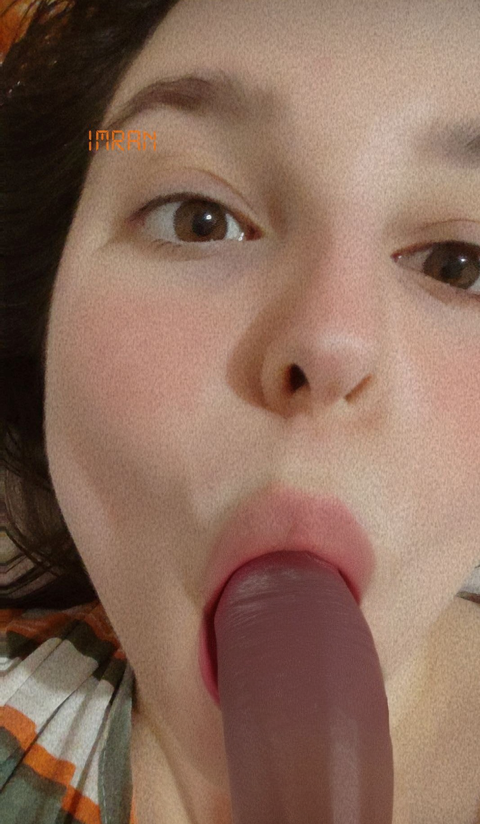

In [6]:
# @title Upload Image
%cd /content/ComfyUI
file_uploaded = upload_image()
display_upload = True # @param {type:"boolean"}
if display_upload:
    if file_uploaded.lower().endswith(('.png', '.jpg', '.jpeg')):
        display(IPImage(filename=file_uploaded))
    else:
        print("The image format cannot be displayed.")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# @title Generate Video

import time
start_time = time.time()

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

positive_prompt = "A woman is performing oral sex on a man. Her head moves up and down as she sucks the penis. The view is POV" # @param {"type":"string"}
negative_prompt = "bad quality, blurry, messy, chaotic" # @param {"type":"string"}
change_resolution=True # @param {type:"boolean"}
new_width = 432 # @param {"type":"number"}
new_height = 768 # @param {"type":"number"}
seed = 0 # @param {"type":"integer"}
use_causvid_lora=True # @param {type:"boolean"}
causvid_lora_strength = 0.8 # @param {"type":"slider","min":-1,"max":1,"step":0.01}
steps = 4 # @param {"type":"integer", "min":1, "max":100}
cfg_scale = 1 # @param {"type":"number", "min":1, "max":20}
sampler_name="uni_pc" # @param ["uni_pc", "uni_pc_bh2", "ddim","euler", "euler_cfg_pp", "euler_ancestral", "euler_ancestral_cfg_pp", "heun", "heunpp2","dpm_2", "dpm_2_ancestral","lms", "dpm_fast", "dpm_adaptive", "dpmpp_2s_ancestral", "dpmpp_2s_ancestral_cfg_pp", "dpmpp_sde", "dpmpp_sde_gpu","dpmpp_2m", "dpmpp_2m_cfg_pp", "dpmpp_2m_sde", "dpmpp_2m_sde_gpu", "dpmpp_3m_sde", "dpmpp_3m_sde_gpu", "ddpm", "lcm","ipndm", "ipndm_v", "deis", "res_multistep", "res_multistep_cfg_pp", "res_multistep_ancestral", "res_multistep_ancestral_cfg_pp","gradient_estimation", "er_sde", "seeds_2", "seeds_3"]
scheduler="simple" # @param ["simple","normal","karras","exponential","sgm_uniform","ddim_uniform","beta","linear_quadratic","kl_optimal"]
frames = 65 # @param {"type":"integer", "min":1, "max":120}
frames = frames+2
# fps = 16 # @param {"type":"integer", "min":1, "max":60}
fps = 15
remove_first_frame=True # @param {type:"boolean"}
match_colors=True # @param {type:"boolean"}
output_format = "mp4" # @param ["mp4", "webm"]
overwrite=True # @param {type:"boolean"}
use_lora_1=False # @param {type:"boolean"}
LoRA_1_Strength=1 # @param {"type":"slider","min":-1,"max":1,"step":0.01}
use_lora_2=False # @param {type:"boolean"}
LoRA_2_Strength=1 # @param {"type":"slider","min":-1,"max":1,"step":0.01}

FRAME_MULTIPLIER = 2 # @param {"type":"number"}
vid_fps = 30 # @param {"type":"number"}

%cd /content/ComfyUI

import random
seed = seed if seed != 0 else random.randint(0, 2**32 - 1)
print(f"Using seed: {seed}")

# with torch.inference_mode():
generate_video(
    image_path=file_uploaded,
    positive_prompt=positive_prompt,
    negative_prompt=negative_prompt,
    change_resolution=change_resolution,
    width=new_width,
    height=new_height,
    seed=seed,
    use_causvid=use_causvid_lora,
    causvid_lora_strength=causvid_lora_strength,
    steps=steps,
    cfg_scale=cfg_scale,
    sampler_name=sampler_name,
    scheduler=scheduler,
    frames=frames,
    fps=fps,
    remove_first_frame=remove_first_frame,
    match_colors=match_colors,
    output_format=output_format,
    overwrite=overwrite,
    use_lora_1=use_lora_1,
    LoRA_1_Strength=LoRA_1_Strength,
    use_lora_2=use_lora_2,
    LoRA_2_Strength=LoRA_2_Strength
)

end_time = time.time()
duration = end_time - start_time
mins, secs = divmod(duration, 60)
print(f"✅ Generation completed in {int(mins)} min {secs:.2f} sec")

clear_memory()

print(f"Converting video to {vid_fps} fps...")

%cd /content/Practical-RIFE

# Suppress ALSA errors
os.environ["XDG_RUNTIME_DIR"] = "/tmp"
os.environ["SDL_AUDIODRIVER"] = "dummy"

# Disable warnings from ffmpeg about missing audio
os.environ["PYGAME_HIDE_SUPPORT_PROMPT"] = "1"
os.environ["FFMPEG_LOGLEVEL"] = "quiet"

!python3 inference_video.py --multi={FRAME_MULTIPLIER} --fps={vid_fps} --video={vid_15fps} --scale={1}
video_folder = "/content/ComfyUI/output/"

# Find the latest MP4 file
video_files = glob.glob(os.path.join(video_folder, "*.mp4"))

if video_files:
    latest_video = max(video_files, key=os.path.getctime)
    !ffmpeg -i "{latest_video}" -vcodec libx264 -crf 18 -preset fast output_converted.mp4 -loglevel error -y

    print(f"Displaying video: {latest_video}")
    display(outVid("output_converted.mp4", embed=True))
    # displayVid(outVid(latest_video, embed=True))
else:
    print("❌ No video found in output/")

del video_files

end_time = time.time()
duration = end_time - start_time
mins, secs = divmod(duration, 60)
print(f"✅ Generation completed in {int(mins)} min {secs:.2f} sec")

clear_memory()

/content/ComfyUI
Using seed: 4032915382
Loading Text_Encoder...
Changing Image Resolution...
Image width is 432 and height is 768
Loading VAE...
Loading Unet Model...
gguf qtypes: F32 (836), Q8_0 (489), F16 (6)


/content/ComfyUI/custom_nodes/ComfyUI_GGUF/loader.py:91: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  torch_tensor = torch.from_numpy(tensor.data) # mmap


Loading causvid Lora...
Generating video...
Attempting to release mmap (569)


  0%|          | 0/4 [00:00<?, ?it/s]

Trimming video latent...
Decoding latents...
Matching color of video frames to Reference Image...
Saving as MP4...


✅ Generation completed in 9 min 55.18 sec
Converting video to 30 fps...
/content/Practical-RIFE
Loaded 3.x/4.x HD model.
/content/ComfyUI/output/output.mp4, 65.0 frames in total, 15.0FPS to 30FPS
Will not merge audio because using png or fps flag!
 98% 64/65.0 [00:04<00:00, 13.97it/s]
Displaying video: /content/ComfyUI/output/output_2X_30fps.mp4


✅ Generation completed in 10 min 16.55 sec
